In [1]:
import os
import sys
# import torch.multiprocessing as mp
# from functools import partial

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.models as models
from PIL import Image
from compressai.models import ScaleHyperprior
from compressai.zoo import bmshj2018_hyperprior
from torch import optim, nn, utils
from torchvision import transforms
from torchmetrics import Accuracy
from torchvision.utils import save_image

import wandb
from pytorch_lightning.loggers import WandbLogger

# mp.set_start_method('spawn', force=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

def make_dataset(filename, datadir, class_to_idx, transform=None):
    images = []
    labels = []
    i = 0
    with open(os.path.join(filename), "r") as lines:
        for line in lines:
            _image = os.path.join(datadir, line.rstrip('\n'))
            _dirname = os.path.split(os.path.dirname(_image))[1]
            assert os.path.isfile(_image)
            label = class_to_idx[_dirname]
            images.append(_image)
            labels.append(label)
            i += 1
            if i % 1000 == 0: sys.stdout.write('\r'+str(i)+' items loaded')
            
    sys.stdout.write('\r'+str(i)+' items loaded')
                           
              
    return images, labels

def preprocess_dataset(root=os.path.expanduser('../')):
    
    root = os.path.join(root, 'minc-2500')
    print(root)

    classes, class_to_idx = find_classes(root + '/images')
    
    for filename in [os.path.join(root, 'labels/train1.txt'), os.path.join(root, 'labels/validate1.txt'), os.path.join(root, 'labels/test1.txt')]:
        print("File: ", filename)

        for quality in [1, 4, 8]:
            print("Quality:", quality)
            compression_model = bmshj2018_hyperprior(quality=quality, pretrained=True).eval().to(device)

            i = 0
            with open(os.path.join(filename), "r") as lines:
                for line in lines:
                    _image = os.path.join(root, line.rstrip('\n'))
                    _dirname = os.path.split(os.path.dirname(_image))[1]
                    _file_name = os.path.join(root, 'enc_dec', f'bpp{quality}', _dirname, os.path.split(_image)[1])
                    assert os.path.isfile(_image)
                    # print(_image, _file_name, _dirname,  os.path.split(_image))

                    _img = Image.open(_image).convert('RGB')

                    _img = transforms.ToTensor()(_img)
                    _img = transforms.Resize(384)(_img)

                    _img = _img.unsqueeze(0).to(device)

                    with torch.no_grad():
                        compressed_rep = compression_model.compress(_img)
                        x_hat = compression_model.decompress(**compressed_rep)

                    x_hat = transforms.Resize(362)(x_hat["x_hat"])

                    save_image(x_hat, _file_name)

                    i += 1
                    if i % 1000 == 0: sys.stdout.write('\r'+str(i)+' items loaded')

        sys.stdout.write('\r'+str(i)+' items loaded')

        

preprocess_dataset()

../minc-2500
File:  ../minc-2500/labels/train1.txt
Quality: 1


/home/kfaria_umass_edu/.conda/envs/ds696-project/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


48000 items loadedQuality: 4
48000 items loadedQuality: 8
48875 items loadedFile:  ../minc-2500/labels/validate1.txt
Quality: 1
2000 items loadedQuality: 4
2000 items loadedQuality: 8
2875 items loadedFile:  ../minc-2500/labels/test1.txt
Quality: 1
5000 items loadedQuality: 4
5000 items loadedQuality: 8
5750 items loaded

In [3]:
# We use the train-validation-test split
# 1 provided in the dataset, with 2125 training images, 125
# validation images and 250 testing images for each class.

class MINCDatasetDecoded(data.Dataset):
    NUM_CLASS = 23

    def __init__(self, root=os.path.expanduser('../'),
                 train=True, quality=1):
        split = 'train' if train == True else 'val'
        root = os.path.join(root, 'minc-2500')
        print(root)
        
        self.classes, self.class_to_idx = find_classes(root + '/images')
        if split == 'train':
            filename = os.path.join(root, 'labels/train1.txt') # 2125
        else:
            filename = os.path.join(root, 'labels/validate1.txt') # 125

        self.images, self.crs, self.labels = make_dataset(filename, root, self.class_to_idx, quality)
        
        self.compression_model = bmshj2018_hyperprior(quality=quality, pretrained=True).eval().to(device)

        assert (len(self.images) == len(self.labels))

    def __getitem__(self, index):
        _image = self.images[index]
        _img = Image.open(_image).convert('RGB')
        _label = self.labels[index]
        
        _img = transforms.ToTensor()(_img)
        _img = transforms.Resize(384)(_img)
    
        _img = _img.unsqueeze(0).to(device)
        
        _x_hat = self.crs[index]
        _x_hat = Image.open(_x_hat).convert('RGB')

        _x_hat = transforms.ToTensor()(_x_hat)
        _x_hat = transforms.Resize(256)(_x_hat)
        _x_hat = transforms.RandomCrop(224)(_x_hat)
        
        _x_hat = transforms.RandomHorizontalFlip()(_x_hat)
        

        return _image, _x_hat, _label

    def __len__(self):
        return len(self.images)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(filename, datadir, class_to_idx, quality):
    images = []
    labels = []
    crs = []
    
    i = 0
    with open(os.path.join(filename), "r") as lines:
        for line in lines:
            _image = os.path.join(datadir, line.rstrip('\n'))
            _dirname = os.path.split(os.path.dirname(_image))[1]
            _compressed_rep = os.path.join(datadir, 'enc_dec', f'bpp{quality}', _dirname, os.path.split(_image)[1])
            print(_compressed_rep)
            assert os.path.isfile(_image)
            assert os.path.isfile(_compressed_rep)
            label = class_to_idx[_dirname]
            images.append(_image)
            crs.append(_compressed_rep)
            labels.append(label)
            
            i += 1
            if i % 1000 == 0: sys.stdout.write('\r'+str(i)+' items loaded')
            
    sys.stdout.write('\r'+str(i)+' items loaded')
                           
              
    return images, crs, labels

In [ ]:
def make_dataset(filename, datadir, class_to_idx, quality):
    images = []
    labels = []
    crs = []
    
    i = 0
    with open(os.path.join(filename), "r") as lines:
        for line in lines:
            _image = os.path.join(datadir, line.rstrip('\n'))
            _dirname = os.path.split(os.path.dirname(_image))[1]
            _compressed_rep = os.path.join(datadir, 'compressed_rep', f'bpp{quality}', _dirname, os.path.splitext(os.path.split(_image)[1])[0])
            assert os.path.isfile(_image)
            assert os.path.isfile(_compressed_rep)
            label = class_to_idx[_dirname]
            images.append(_image)
            crs.append(_compressed_rep)
            labels.append(label)
            
            i += 1
            if i % 1000 == 0: sys.stdout.write('\r'+str(i)+' items loaded')
            
    sys.stdout.write('\r'+str(i)+' items loaded')
                           
              
    return images, crs, labels

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
train_minc = MINCDatasetDecoded(train=False)
train_loader = utils.data.DataLoader(train_minc, batch_size=32)

../minc-2500
../minc-2500/enc_dec/bpp1/brick/brick_000168.jpg
../minc-2500/enc_dec/bpp1/brick/brick_002137.jpg
../minc-2500/enc_dec/bpp1/brick/brick_001525.jpg
../minc-2500/enc_dec/bpp1/brick/brick_001169.jpg
../minc-2500/enc_dec/bpp1/brick/brick_000931.jpg
../minc-2500/enc_dec/bpp1/brick/brick_000286.jpg
../minc-2500/enc_dec/bpp1/brick/brick_001884.jpg
../minc-2500/enc_dec/bpp1/brick/brick_001355.jpg
../minc-2500/enc_dec/bpp1/brick/brick_002380.jpg
../minc-2500/enc_dec/bpp1/brick/brick_000739.jpg
../minc-2500/enc_dec/bpp1/brick/brick_002013.jpg
../minc-2500/enc_dec/bpp1/brick/brick_002442.jpg
../minc-2500/enc_dec/bpp1/brick/brick_001323.jpg
../minc-2500/enc_dec/bpp1/brick/brick_001658.jpg
../minc-2500/enc_dec/bpp1/brick/brick_001295.jpg
../minc-2500/enc_dec/bpp1/brick/brick_000607.jpg
../minc-2500/enc_dec/bpp1/brick/brick_001583.jpg
../minc-2500/enc_dec/bpp1/brick/brick_001418.jpg
../minc-2500/enc_dec/bpp1/brick/brick_000736.jpg
../minc-2500/enc_dec/bpp1/brick/brick_002283.jpg
../minc

/home/kfaria_umass_edu/.conda/envs/ds696-project/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


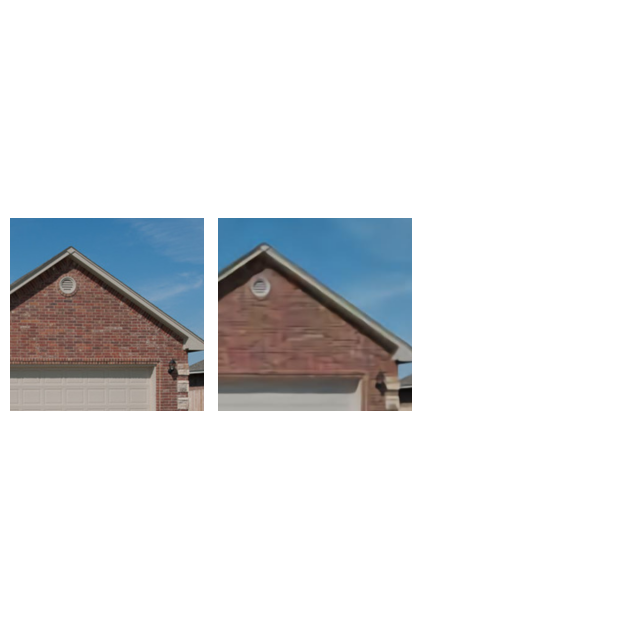

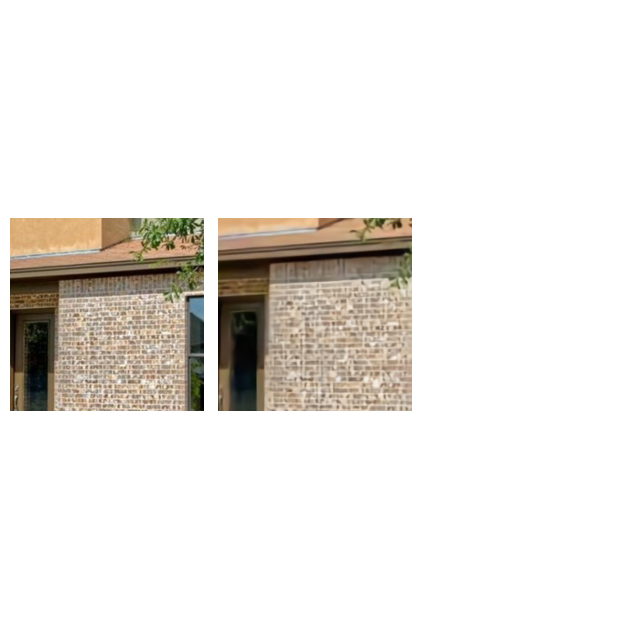

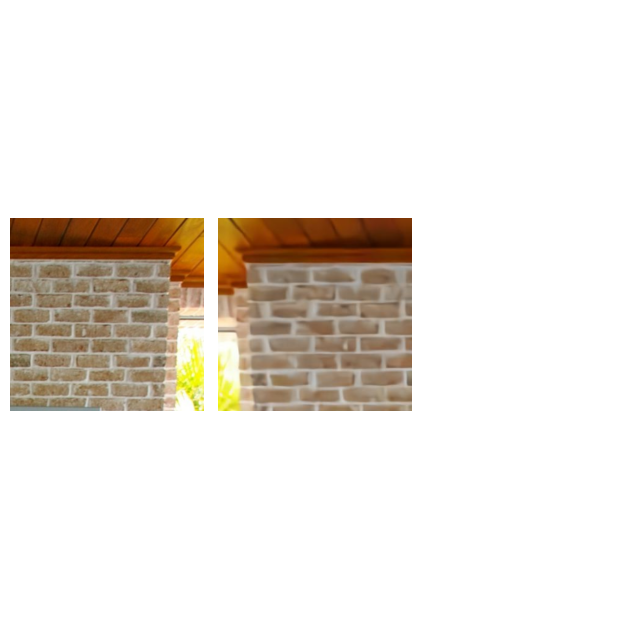

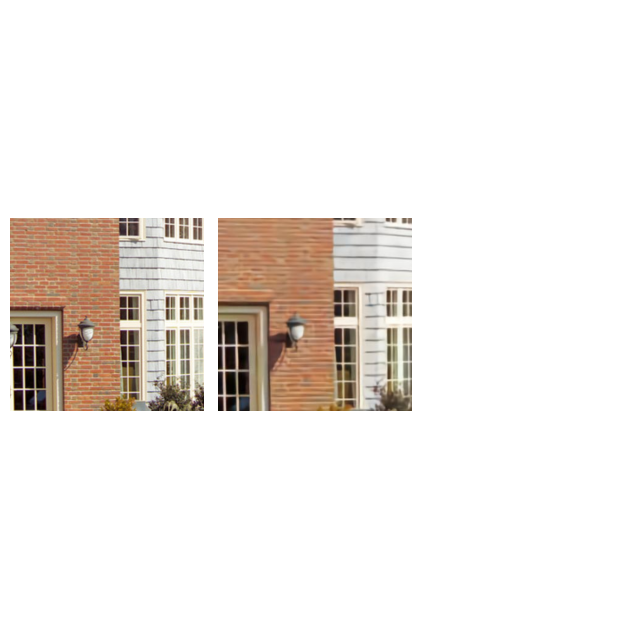

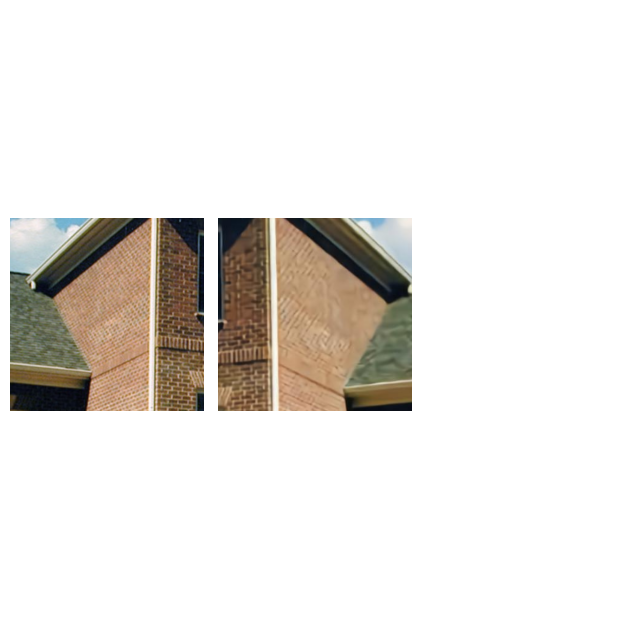

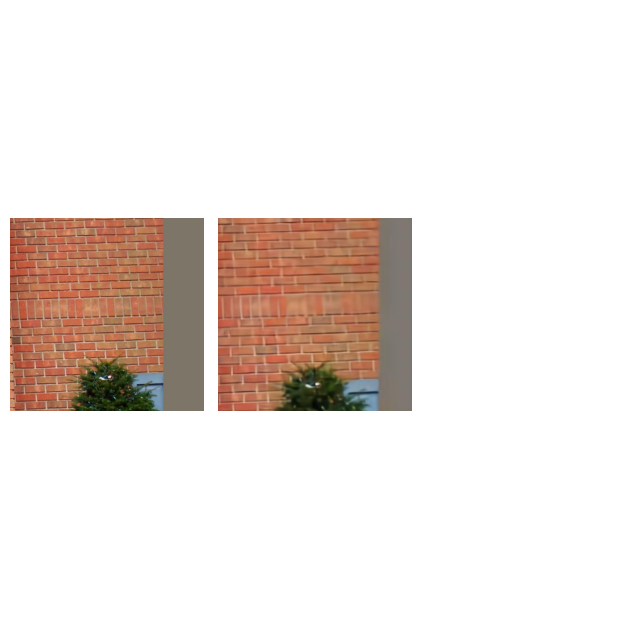

In [8]:
for batch_idx, batch in enumerate(train_loader):
        x, x_hat, target = batch
        
        for idx, img in enumerate(x):
            img = Image.open(img).convert('RGB')
            
            f, axarr = plt.subplots(1,3)
            axarr[0].axis('off')
            axarr[1].axis('off')
            axarr[2].axis('off')
            
            axarr[0].imshow(img)
            
            # print(x_hat[idx].shape)
            axarr[1].imshow(x_hat[idx].cpu().permute(1, 2, 0))
            # axarr[1].title.set_text('latent space')
            
            # axarr[2].imshow(scales_hat[idx].sum(axis=0).cpu())
            # axarr[2].title.set_text('std. dev.')
            
            # f.suptitle(f'Target: {train_minc.classes[target[idx].item()]}, Prediction: {train_minc.classes[torch.argmax(predict[idx])]}, Top 5: {[train_minc.classes[p] for p in torch.topk(predict[idx], 5).indices.tolist()]}', fontsize=10)
            f.tight_layout()
            f.subplots_adjust(top=1.3)
            plt.show()
            
            if idx == 5: break
        
        break

In [7]:
checkpoint_reference = "umass-iesl-is/696ds-learning-based-image-compression/model-sh08q7s9:v0"

# download checkpoint locally (if not already cached)
run = wandb.init(project='696ds-learning-based-image-compression')
artifact = run.use_artifact(checkpoint_reference, type="model")
artifact_dir = artifact.download()

# load checkpoint
downstream_model = cResnet39.load_from_checkpoint(os.path.join(artifact_dir,"model.ckpt"))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kfaria (umass-iesl-is). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model-sh08q7s9:v0, 184.73MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:9.7


NameError: name 'cResnet39' is not defined

In [ ]:
downstream_model.to(device).eval()

with torch.no_grad():
    for batch_idx, batch in enumerate(train_loader):
        x, y_hat, scales_hat, target = batch
        target = target.to(device)

        y_hat, scales_hat = y_hat.to(device), scales_hat.to(device)

        predict = downstream_model(y_hat.T, scales_hat.T)
        loss = F.cross_entropy(predict, target)
        print("top 1:", Accuracy(task="multiclass", num_classes=23).to(device)(predict, target).item())
        print("top 5:", Accuracy(task="multiclass", num_classes=23, top_k=5).to(device)(predict, target).item())
        print("loss :", loss.item())
        
        for idx, img in enumerate(x):
            print("Label", target[idx].item())
            
            img = Image.open(img).convert('RGB')
            
            f, axarr = plt.subplots(1,3)
            axarr[0].axis('off')
            axarr[1].axis('off')
            axarr[2].axis('off')
            
            axarr[0].imshow(img)
            axarr[0].title.set_text('Image')
            
            axarr[1].imshow(y_hat[idx].sum(axis=0).cpu())
            axarr[1].title.set_text('latent space')
            
            axarr[2].imshow(scales_hat[idx].sum(axis=0).cpu())
            axarr[2].title.set_text('std. dev.')
            
            f.suptitle(f'Target: {train_minc.classes[target[idx].item()]}, Prediction: {train_minc.classes[torch.argmax(predict[idx])]}, Top 5: {[train_minc.classes[p] for p in torch.topk(predict[idx], 5).indices.tolist()]}', fontsize=10)
            f.tight_layout()
            f.subplots_adjust(top=1.3)
        
        break
            
            
wandb.finish()

In [ ]:
wandb.finish() 